# **Open Data Examples** | Analyzing Property Ownership
This notebook will walk you through the following:
* Fetch Cuyahoga County GIS and Cuyahoga Fiscal Officer's property data for Cleveland
* Use `cledatatoolkit` library to detect property owners that are corporate (businesses, companies, non-profits, i.e. not individuals)

To run this notebook, you will need to install the following packages using `pip`:
* Cleveland Urban AI's `cledatatoolkit`
* `requests`

In [1]:
import cledatatoolkit as cdt
import requests
import geopandas as gpd
import io

In [2]:
# Download the Cuyahoga County GIS combined parcel dataset for Cleveland only

# Simple function to save a requested URL to file

# This is a URL to the Cleveland Combined parcels dataset geoJSON download from the Cuyahoga County Open Data site.
url = "https://opendata.arcgis.com/api/v3/datasets/a84be47945564300a2119f6b9a411d59_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
# Download the geoJSON and store in-memory
response = requests.get(url)
parcels_geojson = io.BytesIO(response.content)

# Load the parcels into a geodataframe which has full table plus the shape of the parcels in space.
# This could take a couple minutes!
parcels_gdf = gpd.read_file(parcels_geojson).to_crs(epsg=3734)

In [3]:
# Download Cleveland neighborhood boundaries

# Like above, this URL downloads the city neighborhoods from City of Cleveland Open Data.
url = "https://opendata.arcgis.com/api/v3/datasets/b2a2da54401a41e78dd71563f01f5273_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
# Download the geoJSON and store in-memory
response = requests.get(url)
nbhd_geojson = io.BytesIO(response.content)

# Load the parcels into a geodataframe which has full table plus the shape of the parcels in space.
nbhd_gdf = gpd.read_file(nbhd_geojson).to_crs(epsg=3734)

## Spatial Joining - Adding useful geographic attributes
The Cuyahoga County property dataset does not come with a column for City neighborhood, or ward.

In order to break down the property data by those areas, we need to do a "spatial join" that will add that information to parcel dataset based on a *spatial relationship*. In this case, we will use the *largest overlap* relationship. If the property overlaps multiple neighborhoods (less common), it is considered part of the neighborhood with the largest overlap.

In [4]:
joined = cdt.spatial.largest_overlap(target_gdf=parcels_gdf,
                         target_key = 'parcelpin',
                         join_gdf=nbhd_gdf,
                         transfer_field= 'SPANM',
                         new_name= 'Neighborhood')

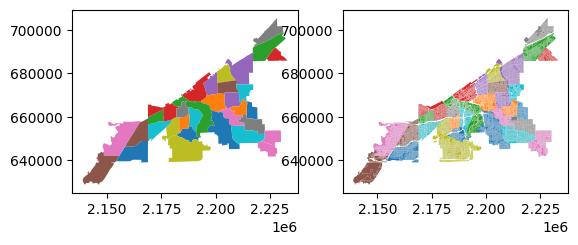

In [5]:
# Plot neighborhoods and parcels data using their respective neighborhood fields.
# We can see the join worked as expected. The parcel layer colored by neighborhood values matches.
import matplotlib.pyplot as plt

fig,axes = plt.subplots(ncols=2)

nbhd_gdf.plot('SPANM', ax=axes[0], linewidth=.1)
joined.plot("Neighborhood", ax = axes[1])
axes[0].set_title = 'Neighborhood Layer'
axes[1].set_title = 'Parcels Joined'

## Analyze Property Ownership
##### Let's now explore the nature of ownership by neighborhood using helper tools in `cledatatoolkit`. 

Cleveland has seen a growing trend of non-owner-occupied property acquisition by corporate entities. These types of owners are informally known as *LLC owners*, though there are a wide variety of corp. structures in addition to LLCs, like Limited Partnerships (LP), S-corps, C-corps, etc.

Bad faith corporate owners, both out-of-state and local, can have negative effects on the housing market by pushing out local buyers with cash offers, avoiding sorely needed physical upkeep, and in some cases evading tax liability through maze-like corporate structuring and transferring. This doesn't describe the majority of corporate owners, and housing issues are more complicated. There are also many normal corporate owners: market and affordable housing developers, education, non-profit and other institutions who acquire land for mission-based purposes or local real estate development. **In any case, being able to track this ownership type is critical for policy, operations, and awareness.**

There is no field in the Cuyahoga property dataset that tracks this ownership type explicitly. The `cledatatoolkit` has a library of regular expressions tailored to parse through `deeded_owner` field for corporate-like patterns.



In [6]:
cdt.property.biz_flag_re

'(?i) ?l\\.? ?l\\.? ?c|\\Winco?|\\Wcorp|\\slp|l-?t-?d|roth ira|limited|\\Wtrs\\W|-?tru?st?|renovations|liability|resource|enterprise|associ?a?t?|acquisition|comi?pany|\\Wco$|llp|\\Wl\\.?p\\.?\\W?|management|financial|development|network|invest|co-t|construct|property|properties|solution|buil(der)?|real estate|services|realty|partners?|li?m?i?te?d'

The above is a regular expression. It defines a specific pattern of text to identify using a search algorithm. [Regular expressions](https://en.wikipedia.org/wiki/Regular_expression) are found all over computer software search tools, and can find more complicated patterns.

Urban Analytics has a function that applies various regular expressions to a column of `deeded_owner` values and approximates if it is a corporate-type owner.

In [7]:
# Use the identify_corp_owner function from our toolkit
# This is performed by identifying business type owner names, special corp. owners, and exclusions.
joined['Corporate Owned'] =  cdt.property.identify_corp_owner(joined['deeded_owner'])

/home/dns/workspaces/UrbanAI/cledatatoolkit/src/cledatatoolkit/property.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  biz_test = owner_column.str.contains(biz_flag_re)
/home/dns/workspaces/UrbanAI/cledatatoolkit/src/cledatatoolkit/property.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exclude_test = owner_column.str.contains(exclude_re).fillna(False)


In [8]:
# Break down by neighborhood the total count of identified corp owners
spa_grouped = joined[['Neighborhood', 'Corporate Owned']].groupby('Neighborhood').agg('sum')

In [9]:
# Calculate total # of parcels by ward
spa_grouped['Total'] = joined.groupby('Neighborhood')['parcelpin'].agg('count')
# Calculate the difference, i.e. non-corporate matches
spa_grouped['Non-Corporate'] =  spa_grouped['Total'] - spa_grouped['Corporate Owned']
# Calculate percent of neighborhood owned by corporate flagged owner name
spa_grouped['Percent Corporate'] = 100 * spa_grouped['Corporate Owned'] / spa_grouped['Total']

<Axes: title={'center': 'Count of Parcels by Neighborhood and Owner Type'}, ylabel='Neighborhood'>

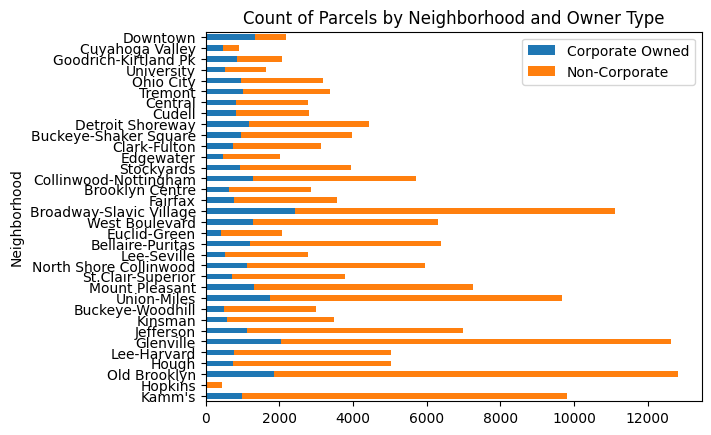

In [16]:
# Final result visualizing ratio of corp vs non-corp owner types, and overall # of parcels
spa_grouped.sort_values('Percent Corporate')[['Corporate Owned', 'Non-Corporate']].plot( kind='barh', stacked=True, title='Count of Parcels by Neighborhood and Owner Type')

# Results by Count and Percent

**Among all neighborhoods, Slavic Village has the highest total count of corporate-owned properties.**
This is supported by [reports of Slavic Village as the "epicenter" of the Great Recession](https://www.theguardian.com/cities/2015/jun/18/epicentre-great-recession-cleveland-slavic-village-foreclosure). The data suggests that after the housing market collapsed companies and other corporate entities have become more prominent owners in this large neighborhood, a pattern that isn't unique to Slavic Village or Cleveland.

By percentage of parcels, Downtown, a center for retail and business activity, is at the top of the list, alongside other industrial, commmercial and institutional neighborhoods.

<Axes: title={'center': 'Percent of Parcels Identified as Corporate Type'}, ylabel='Neighborhood'>

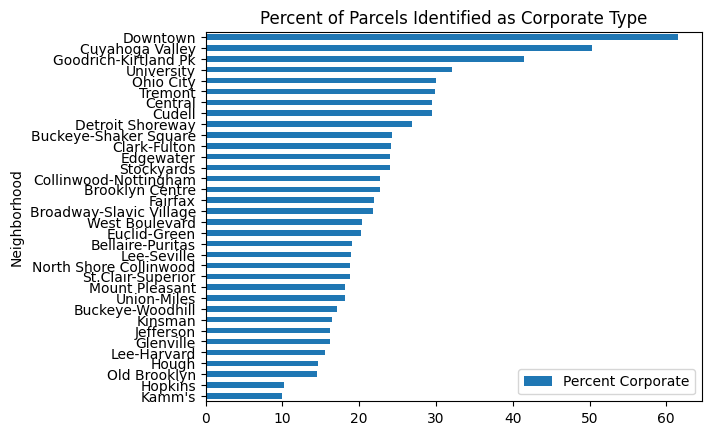

In [15]:
spa_grouped.sort_values('Percent Corporate').plot(y='Percent Corporate', kind='barh', title='Percent of Parcels Identified as Corporate Type')